In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

from scbeta_scrnaseq.figure_vis import core_colors
import scbeta_scrnaseq.figure_vis as fv


fv.setup_matplotlib_params()
mm_per_inch = 25.4

Populating the interactive namespace from numpy and matplotlib


In [2]:
pb_tpm_z = utils.load_df('../01_Stages_3_to_6/data/complete_processing/x1x2.pb_tpm.z_scores.highvar.df.npz')

In [3]:
from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage
from scipy.cluster.hierarchy import dendrogram, leaves_list, fcluster, to_tree, leaders

import polo
pb_dist = pdist(pb_tpm_z.values, 'correlation')
pb_link = linkage(pb_dist, 'average')
pb_link = polo.polo.optimal_leaf_ordering(pb_link, pb_dist)



In [4]:
D = pd.DataFrame(squareform(pb_dist), index=pb_tpm_z.index, columns=pb_tpm_z.index)
lo = leaves_list(pb_link)
lo = lo[::-1]
D = D.iloc[lo, :].iloc[:, lo]

pb_link_groups = fcluster(pb_link, 0.6, criterion='distance')[lo]
grp_sep_locations = np.where(pb_link_groups[:-1] != pb_link_groups[1:])[0] 

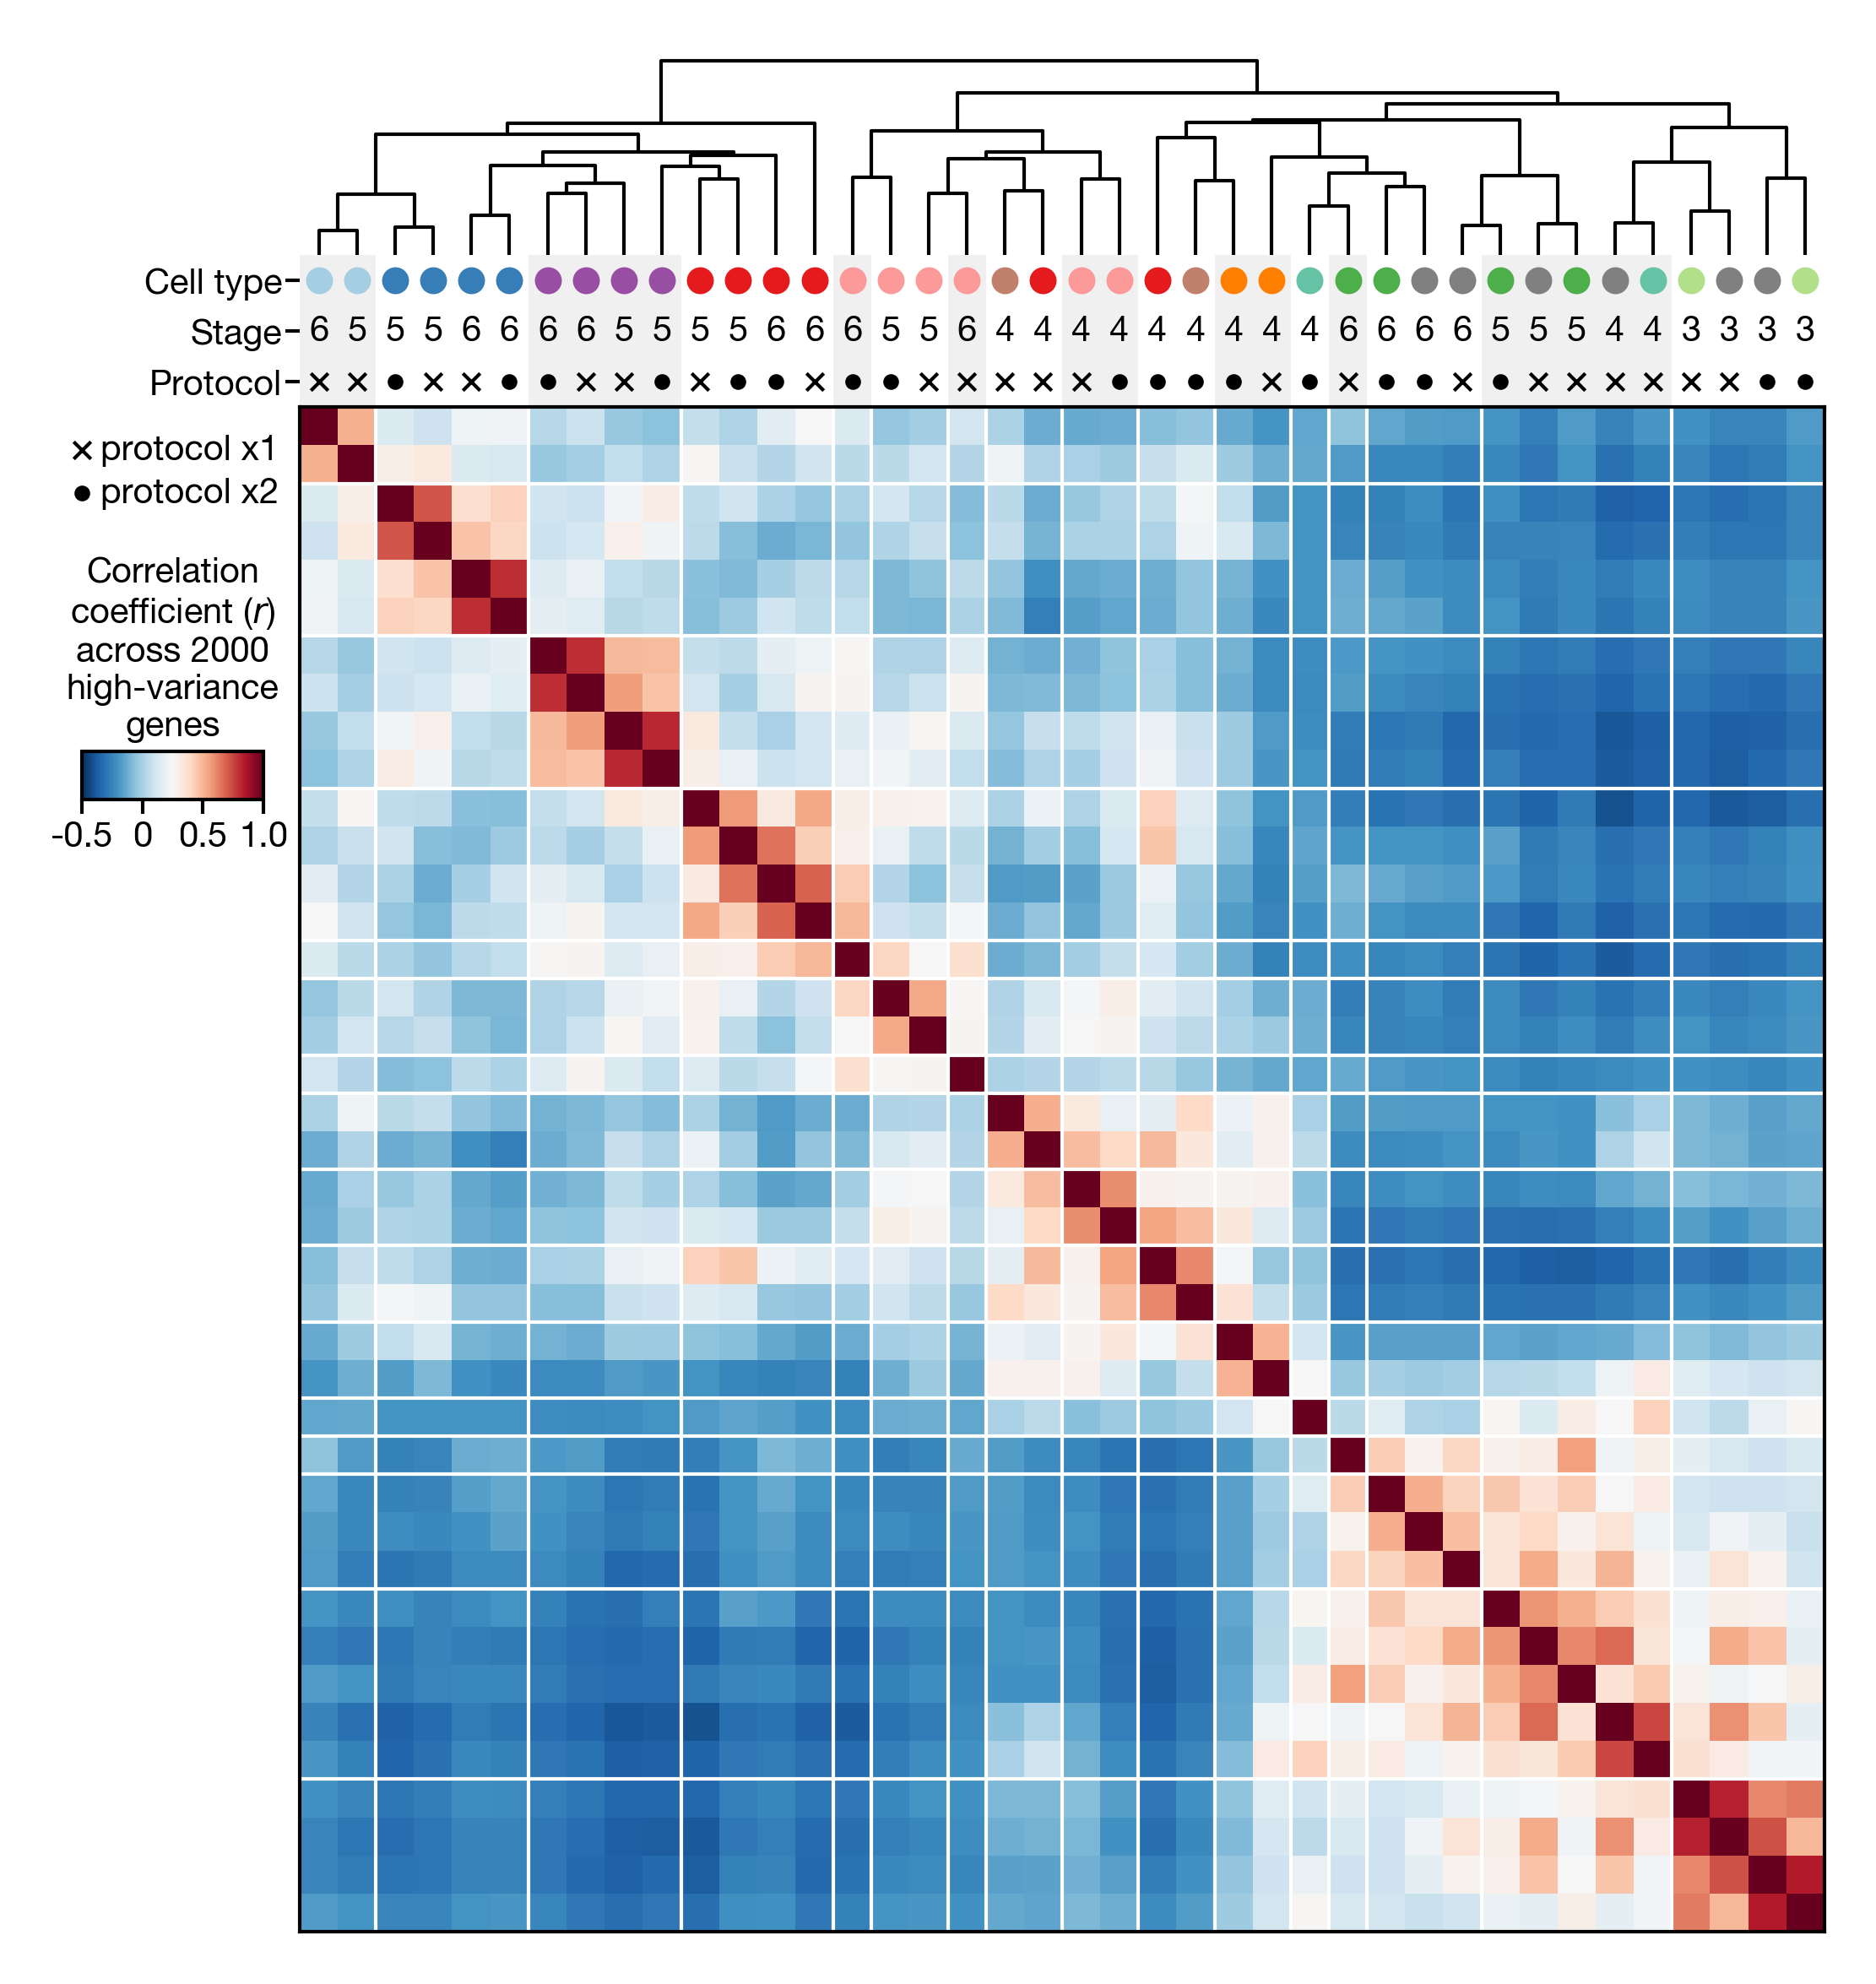

In [11]:
_w = 91/mm_per_inch

width_ratios = [0.5, 3]
height_ratios = [0.4,0.3, 3]

_h = _w/(sum(width_ratios)/sum(height_ratios))

fig = plt.figure(figsize=(_w, _h), dpi=600)
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios), fig, 0.01, 0.01, 0.99, 0.99 ,
                       width_ratios=width_ratios, height_ratios=height_ratios,
                       hspace=0, wspace=0)

ax = fig.add_subplot(gs[0,1], xscale='linear', yscale='linear', xticks=[], yticks=[],
        xlabel='', ylabel='', frameon=False)

with plt.rc_context({'lines.linewidth': 0.5}):
    dendrogram(pb_link, orientation='top', link_color_func=lambda k: 'k')
ax.set_xticks([])
    
    
ax = fig.add_subplot(gs[1,1], xscale='linear', yscale='linear', xticks=[], yticks=[],
        xlabel='', ylabel='', frameon=False)

ax.set_xlim([-0.5, len(lo)-0.5])
ax.set_xticks([])

ytick_labels = ["Protocol", "Stage", "Cell type"]
ax.set_ylim([-0.5, len(ytick_labels)-0.5])
ax.set_yticks(range(len(ytick_labels)))
ax.set_yticklabels(ytick_labels)

ax.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)
for i,lab in enumerate(D.index):
    sample, cl = lab.split(' ')
    sym,ss = ('x',6) if (lab[1] == '1') else ('o', 3)
    ax.scatter([i], [2], c=fv.dataset_label_params(sample)[cl]['color'].reshape(1,-1), s=8)  
    ax.text(i, 1, lab[4], verticalalignment='center', horizontalalignment='center',
            fontsize=5, clip_on=False)
    
    
    ax.scatter([i], [0], c='k', s=ss, marker=sym, linewidth=0.5)

last_sep = 0

ext_grp_sep_locations = [0] + list(grp_sep_locations+1) + [len(lo)]

for i,grp_sep in enumerate(ext_grp_sep_locations[:-1]):
    
    next_grp_sep = ext_grp_sep_locations[i+1]
    grp_color = '#f0f0f0' if i%2==0 else '#ffffff'
    ax.add_patch(
                patches.Rectangle(
                    (grp_sep-0.5, -0.5), next_grp_sep-grp_sep, len(ytick_labels),
                    facecolor=grp_color, edgecolor='none', linewidth=0.5, zorder=-10
                ))
    


ax = fig.add_subplot(gs[2,1], xscale='linear', yscale='linear', xticks=[], yticks=[],
        xlabel='', ylabel='', frameon=True)

vmin, vmax= (-0.5,1)
cmap = 'RdBu_r'
im = ax.imshow(1-D.values[::-1, :],  cmap=cmap, aspect='auto', origin='lower',
               vmin=vmin, vmax=vmax)

for grp_sep in grp_sep_locations:
    ax.axvline(grp_sep+0.5, color='w', linewidth=0.5)
    ax.axhline(len(lo)-grp_sep-1.5, color='w', linewidth=0.5)

#
# Color bar
#
#

cax_position = [0.03, 0.60, 0.10, 0.025]

cax2 = fig.add_axes(cax_position,
                xscale='linear', yscale='linear',
                xlabel='', ylabel='', frameon=True, )

with plt.rc_context({'axes.linewidth': 0.5}):
    cb = fig.colorbar(im, cax=cax2, orientation='horizontal', ticks=[-0.5, 0, 0.5, 1.0])
    cb.ax.xaxis.set_label_position('top')
    
    cb.set_ticklabels(['-0.5', '0', '0.5', '1.0'])
#     cb.ax.tick_params(labelsize=5, width=0.5, pad=1.00, length=2)
    cb.ax.text(0.25, 1.3, 'Correlation\n'r'coefficient ($\it{r}$)''\nacross 2000\nhigh-variance\ngenes',
               verticalalignment='bottom', horizontalalignment='center',
               fontsize=5, clip_on=False,
              )

#
# Protocol legend
#
#

cax_position = [0.03, 0.75, 0.10, 0.05]

cax2 = fig.add_axes(cax_position,
                xscale='linear', yscale='linear',
                    xlim=(0,1), ylim=(0,1),
                    xticks=[], yticks=[],
                xlabel='', ylabel='', frameon=False, )

cax2.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)
for yy, sym, ss, lab in [(0.65, 'x', 6, 'x1'), (0.20, 'o', 3, 'x2')]:
    cax2.scatter([0.0], [yy], s=ss, marker=sym, linewidth=0.5, color='k', clip_on=False)
    cax2.text(0.10, yy, 'protocol '+lab, verticalalignment='center', horizontalalignment='left',
            fontsize=5, clip_on=False)
    
fig.savefig('../../figures/components/extended_figure1/x1x2_corr_heatmap.pdf', transparent=True)